<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".


Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.


В обучающей выборке *train_sessions.csv*:

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем *site_dic.pkl*)
Признаки time_j – время посещения сайтов site_j
Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)
Задача – сделать прогнозы для сессий в тестовой выборке (*test_sessions.csv*), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой *train_sessions.csv* – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

In [20]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
import pickle
from collections import Counter
import math
import operator
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import datetime 

from scipy.sparse import hstack
import itertools
from sklearn.model_selection import TimeSeriesSplit

In [21]:
list(itertools.combinations(['1','2','3'], 3))


[('1', '2', '3')]

Reading original data

In [22]:
# Read the training and test data sets
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')
#test_df = test_df.sort_values(by='time1')
#train_df = train_df[(train_df['time1'] > datetime.date(year=2013,month=10,day=1))]

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [23]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
times = ['time%s' % i for i in range(1, 11)]

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
19530,www.detiendasporelmundo.es
47716,wms.assoc-amazon.co.uk
35883,www.chango.com
38531,thiliniishaka.blogspot.com
23959,i1-js-14-3-01-10334-425609165-i.init.cedexis-r...


In [24]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

Separate target feature 

In [25]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [26]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [27]:




scaler = MinMaxScaler()


times = ['time%s' % i for i in range(1, 11)]
train_df['duration'] = (train_df[times].max(axis=1) - train_df['time1']).dt.seconds
#test_df['duration'] = (test_df[times].max(axis=1) - test_df['time1']).dt.seconds//60
test_df['duration'] = (test_df[times].max(axis=1) - test_df['time1']).dt.seconds



alice_words = train_df[(train_df['target'] == 1)][sites]
alice_words['alice_text'] = alice_words[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
alice_words_list = [word for word in alice_words['alice_text'].apply(lambda x: x.split(' '))]
alice_flatten = list(np.array(alice_words_list).flat)
alice_most_freq_sites = Counter(alice_flatten)#.most_common(100)

alice_time = train_df[(train_df['target'] == 1)]['duration']

print(alice_time.describe())

test_df['duration_alice_mean'] = ((test_df[times].max(axis=1) - test_df['time1']).dt.seconds 
                                  > alice_time.mean()).astype(int)
train_df['duration_alice_mean'] = ((train_df[times].max(axis=1) - train_df['time1']).dt.seconds 
                                   > alice_time.mean()).astype(int)

delta_test = (test_df[times].max(axis=1) - test_df['time1']).dt.seconds
delta_train = (train_df[times].max(axis=1) - train_df['time1']).dt.seconds


test_df['duration_alice_mean50'] = ((10 > delta_test) & (delta_test > 12)).astype(int)
train_df['duration_alice_mean50'] = ((10 > delta_train) & (delta_train > 12)).astype(int)

test_df['duration_alice_mean75'] = ((35 > delta_test) & (delta_test > 45)).astype(int)
train_df['duration_alice_mean75'] = ((25 > delta_train) & (delta_train > 55)).astype(int)

#print(alice_most_freq_sites.most_common(50))
alice_top_sites  = sorted(alice_most_freq_sites, key=alice_most_freq_sites.get, reverse=True)[:10]

#print(train_df[times].max(axis=1))
#train_df.head()
#alice_top_sites.remove('0')
#print(alice_top_sites)

#print(train_df.columns)
#print(test_df.columns)

vectorizer = TfidfVectorizer(ngram_range=(1,7), max_features=150000, max_df=0.5)
vectorizer.fit(site_dict.keys())

count    2297.000000
mean       52.296474
std       153.309014
min         0.000000
25%         4.000000
50%        11.000000
75%        38.000000
max      1763.000000
Name: duration, dtype: float64


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=150000, min_df=1,
        ngram_range=(1, 7), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [87]:
def build_features(df, new_features, OHE, isScalerRequired, tfidRequired, heatmap):
    #df["start_session_year_13"] = (df['time1'].dt.year == 13).astype(int)
    #df["start_session_year_14"] = (df['time1'].dt.year == 14).astype(int)
    
    #df['session_ed'] = df[times].apply(lambda x: x !=None, axis=1)
    
    

    
    df["start_session_hour"] = df['time1'].dt.hour
    df["start_session_day_night"] = ((df['time1'].dt.hour > 20) | (df['time1'].dt.hour < 7)).astype(int)
    df["start_session_morning"] = ((df['time1'].dt.hour > 6) & (df['time1'].dt.hour < 11)).astype(int)
    
    df['start_session_month'] = df['time1'].dt.month
    df['start_session_day'] = df['time1'].dt.day
    #df['start_session_week'] = df['time1'].dt.week
    df['start_session_week'] = (df['time1'].dt.day) // 7
    df['year_month'] = df['time1'].dt.year.astype(str)+df['time1'].dt.month.astype(str)
    df['yyyymm'] = df['time1'].dt.strftime('%Y%m').astype(int)

    
    df['start_session_day_of_the_week'] = df['time1'].dt.dayofweek
    #df['start_session_15'] = (df['time1'].dt.hour == 15).astype(int) 
    #df['start_session_16'] = (df['time1'].dt.hour == 16).astype(int)
    #df['start_session_18'] = (df['time1'].dt.hour == 18).astype(int)
    df["is_monday"] = df['time1'].dt.weekday.isin([0])*1 #индикатор выходных
    df["is_tuesday"] = df['time1'].dt.weekday.isin([1])*1 #индикатор выходных
    df["is_wednesday"] = df['time1'].dt.weekday.isin([2])*1 #индикатор выходных
    df["is_thursday"] = df['time1'].dt.weekday.isin([3])*1 #индикатор выходных
    df["is_friday"] = df['time1'].dt.weekday.isin([4])*1 #индикатор выходных

    df["is_saturday"] = df['time1'].dt.weekday.isin([5])*1 #индикатор выходных
    df["is_sunday"] = df['time1'].dt.weekday.isin([6])*1 #индикатор выходных
    
    df["12_14_16_19"] = (((df['time1'].dt.hour >= 12) & (df['time1'].dt.hour <= 14)) | 
                        ((df['time1'].dt.hour >= 16) & (df['time1'].dt.hour <= 19))).astype(int)
   
    df["12_13"] = ((df['time1'].dt.hour >= 12) & (df['time1'].dt.hour <= 13)).astype(int)
    df["13_14"] = ((df['time1'].dt.hour >= 12) & (df['time1'].dt.hour <= 14)).astype(int)
    df["16_18"] = ((df['time1'].dt.hour >= 16) & (df['time1'].dt.hour <= 18)).astype(int)
    df["18_20"] = ((df['time1'].dt.hour > 18) & (df['time1'].dt.hour <= 20)).astype(int)
    df["20_24"] = (df['time1'].dt.hour > 20).astype(int)

    df["00_02"] = ((df['time1'].dt.hour > 0) & (df['time1'].dt.hour <= 2)).astype(int)
    df["02_04"] = ((df['time1'].dt.hour > 2) & (df['time1'].dt.hour <= 4)).astype(int)
    df["04_06"] = ((df['time1'].dt.hour > 4) & (df['time1'].dt.hour <= 6)).astype(int)
    df["06_09"] = ((df['time1'].dt.hour > 6) & (df['time1'].dt.hour <= 8)).astype(int)

    df["15_19"] =  ((df['time1'].dt.hour >= 15) & (df['time1'].dt.hour <= 19)).astype(int)
   
    #print(df['session_time'].unique())

    
    #---------------------------------------
    df['text'] = df[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
    df['text'] = df['text'].apply(lambda x: x.replace('0', ''))
    #vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
    bag_of_words = (df['text'].apply(lambda x: x.strip().split(' ')).astype(str)).values
    tfidf_data = vectorizer.transform(df['text'].values)
    #pr
    
    #tfidf = TfidfTransformer()
    #tfidf_data = tfidf.fit_transform(csr_matrix((df['text'].apply(lambda x: x.strip().split(' ')).astype(str))))
    
    #---------------------------------------
    
    df['alice_top_words'] = (df[sites].astype(str).isin(alice_top_sites)==True).sum(axis=1)


    print(df['duration'].unique())

    
    train_data = pd.get_dummies(df[new_features], columns=OHE)
    
    #print(train_data.info())
    #print(tfidf_data.shape)
    
    #print(df.head())
    #print(df['start_session_week'].unique())
   
    #print(train_data.columns.tolist())
    #print(type(train_data)

    if heatmap == True:
        fig, ax = plt.subplots(figsize=(20,20)) 
        sns.heatmap(train_data.corr(), ax=ax);
        plt.show()
        print('WITH HEEATMAP')
    
    #----------------------------------
    #print(train_data.shape)
    #csr_matrix(train_data)
    #print(train_data.info())

    #train_full = None
    if tfidRequired == True:
        train_full = hstack((csr_matrix(train_data), tfidf_data), format='csr')
        print('WITH TFIDF')
    else:
        train_full = csr_matrix(train_data)
    if isScalerRequired == True:
        scaler = StandardScaler(with_mean=False)
        train_full = scaler.fit_transform(train_full)
        print('WITH SCALER')
        
    #-------------------------------------------------
   
    return train_full

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
tscv = TimeSeriesSplit(n_splits=5)
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [92]:
%%time

# features = {
#             'alice_top_words': True,
#             'session_time':True,
#              'year_month':True,
#               'start_session_month':True,
#                'start_session_day':True,
#                'start_session_day_of_the_week':True,
#                'is_saturday':True,
#                 'is_sunday':True,
#                }


# features = {
#             'alice_top_words': True,
#              'year_month':True,
#                 'start_session_day_of_the_week':True,
#     'start_session_hour':True,
#     'duration_alice_mean':False
#                }0.925
# first look score: 0.9430053035359192
# Max auc_roc: 0.9694664388174052

# hours_range = ['09_13',
#                '13_14',
#                '14_18',
#                 '06_09',
#                 '18_20'
#                 ]

# features = {
#             'alice_top_words': True,
#              'year_month':True,
#                 'start_session_day_of_the_week':True,
#     'start_session_hour':True,
#     'duration_alice_mean':False,
#     'duration_alice_mean50':False,
#     'duration_alice_mean75':False
#                }

# first look score: 0.9428125401207617
# Max auc_roc: 0.9697928481881679
#  0.92677,


# features = {
#             'alice_top_words': True,
#              'year_month':True,
#                 'start_session_day_of_the_week':True,
#     'start_session_hour':True,
#     'duration_alice_mean':False,
#     'duration_alice_mean50':False,
#     'duration_alice_mean75':False,
#     'duration':False
#                }

#sУдалить старье!!!!!!!!!!!!!!!!!!!
# features = {
#             'alice_top_words': True,
#              'year_month':True,
#     'duration_alice_mean75':False,
#     'is_monday':False,
#     'is_tuesday':False,
#         'is_wednesday':False,
#         'is_thursday':False,
#         'is_friday':False,
#         'is_saturday':False,
#         'is_sunday':False
# }
#Add features based on the session start time: hour, whether it's morning, day or night and so on.

features = {
            'alice_top_words': True,    
        'is_monday':False,
    'is_tuesday':False,
        'is_thursday':False,
        'is_friday':False,

               }


hours_range = [  '12_13', '16_18']

features_for_processing = list(features.keys())
total_features = len(features_for_processing)

import logging
logging.basicConfig(filename='processing.log', level=logging.INFO)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26 µs


In [93]:
#list(np.arange(0.0, 2, 0.01))
np.logspace(-3, 1, 10)

array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])

feature combinations: 1
HOT: ['alice_top_words']
['is_monday', 'is_thursday', 'is_tuesday', 'is_friday', 'alice_top_words', '12_13', '16_18']
************************************************************
try:  1
[   0 1786    4 ... 1330 1409 1640]


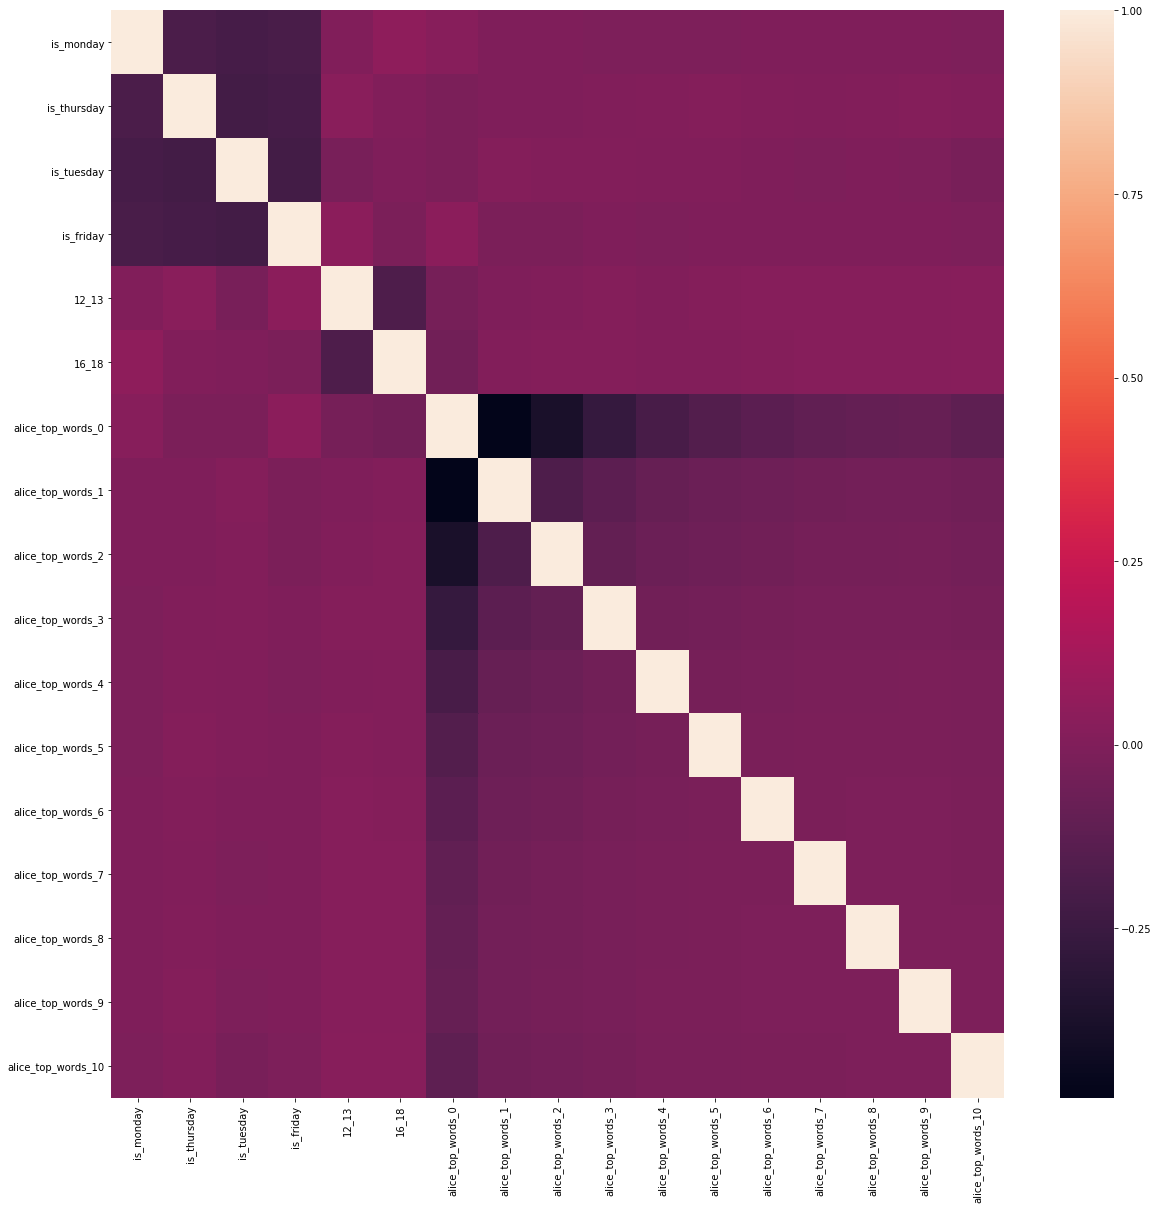

WITH HEEATMAP
WITH TFIDF
WITH SCALER
first look score: 0.9542940301776731
feature combinations: 2
feature combinations: 3
feature combinations: 4
feature combinations: 5
CPU times: user 26.6 s, sys: 1.05 s, total: 27.7 s
Wall time: 26.8 s


In [94]:
%%time
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

idx_split = train_df.shape[0]
logging.info('Started')
import sys

file_num = 1
for i in range(1, total_features +1):
    print('feature combinations:',i)
    logging.info('feature combinations: '+str(i))
    
    
    
    for_process = list(itertools.combinations(features_for_processing, len(features)))#<---i--------------------------
    for combination in for_process:
        features_last = list(combination)
        
        
        if file_num >= 2:
            break
        
        hot = [x1 for x1 in features_last if features[x1] == True]
        print('HOT:',hot)
        
        features_last.extend(hours_range)
        print(features_last)
        logging.info('******'*10)
        print ('******'*10)
        logging.info(features_last)
        logging.info('file:'+'baseline_'+str(file_num)+'.csv')
        print ('try: ', file_num)
        
        #np.arange(0.0, 2, 0.01)
        #list(np.power(10.0, np.arange(-10, 10)))
        
        file_num +=1
        #if file_num > 20:
        #    break
        try:
            
            cs = np.logspace(-3, 1, 10)
            X_full = build_features(full_df, features_last, hot, 
                                    True, True, True)#<---------scal, tfidf, heatmap--------------------------
            X_train = X_full[:idx_split, :]
            score = get_auc_lr_valid(X_train, y_train)
            print('first look score:',score)
            logging.info('first look score: '+str(score))
            
            break
            searchCV = LogisticRegressionCV(
                Cs=cs
                ,scoring='roc_auc'
                ,cv=tscv
                ,random_state=17)
            searchCV.fit(X_train, y_train)
            max_auc = searchCV.scores_[1].max()
            print ('Max auc_roc:', max_auc)
            logging.info('Max auc_roc:'+str(max_auc))

            X_test = X_full[idx_split:,:]
            y_test = searchCV.predict_proba(X_test)[:, 1]
            
            # Write it to the file which could be submitted
            write_to_submission_file(y_test, 'baseline_'+str('file_num')+'.csv')#<-------file_num-----------------------
            break
            #break#<---1-------------------------
        except:
            print ("Unexpected error:", sys.exc_info())
            raise
            #logging.error('Unexpected:' +str(sys.exc_info()[0]))
            #break#<--------------------------------

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

Add features based on the session start time: hour, whether it's morning, day or night and so on.

# You code here
-кол-во сайтов в сессии из ТОП-10 принадлежащих Элис
-месяц начала сессии
-год начала сессии
-час н.с.
-день недели н.с.
-длительность сессии
-средняя длительность сессии

- час
- месяц
- день недели

- утро (0/1)
- ночь (0/1)
- ГГГГММ


сайт == слово 
row - предложение типо

т.е индексы сайтов нужно склеить через пробел в одну строку для каждой сессии, и к этому уже tfidf применять?


Я попробовал обратно замапить id-шники сайтов в URL, потом разбить на компоненты и сделать TF-IDF от получившихся слов. Но что-то это не помогло, хотя считало долго 

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

Perform cross-validation with logistic regression.

Make prediction for the test set and form a submission file.